### Import the needed libraries:

In [185]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time

from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn.model_selection import train_test_split, cross_validate, KFold, GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, fbeta_score, make_scorer, f1_score, recall_score

from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

sns_palette = sns.color_palette("Set1")

### Load the data:

In [186]:
data = pd.read_excel("Dry_Bean_Dataset.xlsx")

### Separate the class from the rest:

In [187]:
X = data.drop(['Class'], axis=1) # everything except the class
y = data['Class']  # only the class

### Quick overview of the data:

In [188]:
X.head()

,Area,Perimeter,MajorAxisLength,MinorAxisLength,AspectRation,Eccentricity,ConvexArea,EquivDiameter,Extent,Solidity,roundness,Compactness,ShapeFactor1,ShapeFactor2,ShapeFactor3,ShapeFactor4
0,28395,610.291,208.178117,173.888747,1.197191,0.549812,28715,190.141097,0.763923,0.988856,0.958027,0.913358,0.007332,0.003147,0.834222,0.998724
1,28734,638.018,200.524796,182.734419,1.097356,0.411785,29172,191.272750,0.783968,0.984986,0.887034,0.953861,0.006979,0.003564,0.909851,0.998430
2,29380,624.110,212.826130,175.931143,1.209713,0.562727,29690,193.410904,0.778113,0.989559,0.947849,0.908774,0.007244,0.003048,0.825871,0.999066
3,30008,645.884,210.557999,182.516516,1.153638,0.498616,30724,195.467062,0.782681,0.976696,0.903936,0.928329,0.007017,0.003215,0.861794,0.994199
4,30140,620.134,201.847882,190.279279,1.060798,0.333680,30417,195.896503,0.773098,0.990893,0.984877,0.970516,0.006697,0.003665,0.941900,0.999166


In [189]:
y.head()

0    SEKER
1    SEKER
2    SEKER
3    SEKER
4    SEKER
Name: Class, dtype: object

### Check for missing values:
All values except class ar numerical, so we can find missing values by checking if the type of every cell is numpy.float64.

In [190]:
count = 0
total = 16*len(X)
for i in range(1,16):
    if i == 6: # column 0 and 6, unlike all others, have integers instead of floats
        continue # so we skip this column for the float check
    for j in range(len(X)):
        if isinstance(X.iloc[j,i], np.floating):
            count += 1
        else:
            print("missing value at [%i ,%i]" % (j,i))

for i in [0,6]:
    for j in range(len(X)):
        if isinstance(X.iloc[j,i], np.integer):
            count += 1
        else:
            print("missing value at [%i ,%i]" % (j,i))

print("number of cells = %i ; number of non-empty cells = %i" % (total, count))

number of cells = 217776 ; number of non-empty cells = 217776


This shows that there are no missing values in the dataset.

### A function to perform hold-out training and testing of a model:

In [191]:
def hold_out(model_label, model, X, y, scale=None, n=10):

    # if a scaling method is given, perform scaling
    if scale is not None:
        model = make_pipeline(scale, model)

    # dataframe for results for each split
    results = pd.DataFrame(columns=['Split/Fold', 'Method', 'Algorithm', 'Scaling', 'Accuracy', 'Micro F1-score', 'Macro F1-score', 'Training time'])
    #results = []

    # perform the hold out method n times with n different seeds
    for i in range(n):

        # split the data into training and testing set
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=i)

        # train the model on the train set
        start = time.time()
        model.fit(X_train, y_train)
        end = time.time()
        tr_time = end - start

        # predict values for the test set
        y_predicted = model.predict(X_test)

        # calculate metrics
        acc = accuracy_score(y_test, y_predicted)
        f1_micro = f1_score(y_test, y_predicted, average="micro") / n
        f1_macro = f1_score(y_test, y_predicted, average="macro") / n


        result =  {'Split/Fold': i+1,
                   'Method': 'Hold out',
                   'Algorithm': model_label,
                   'Scaling': 'None' if scale is None else type(scale).__name__,
                   'Accuracy': acc,
                   'Micro F1-score': f1_micro,
                   'Macro F1-score': f1_macro,
                   'Training time': tr_time}

        results.loc[len(results)] = result

    return results

### Make a dataframe to store results and use holdout function with different scaling methods:

In [192]:
res_ho = pd.DataFrame(columns=['Split/Fold', 'Method', 'Algorithm', 'Scaling', 'Accuracy', 'Micro F1-score', 'Macro F1-score', 'Training time'])

Use the support vector machine classifier:

In [193]:
res_ho =  pd.concat([res_ho, hold_out("SVM", SVC(), X, y)])
res_ho =  pd.concat([res_ho, hold_out("SVM", SVC(), X, y, scale=StandardScaler())])
res_ho =  pd.concat([res_ho, hold_out("SVM", SVC(), X, y, scale=MinMaxScaler())])

Use the logistic regression classifier:

In [194]:
res_ho = pd.concat([res_ho, hold_out("Logistic Regression", LogisticRegression(), X, y)])
res_ho = pd.concat([res_ho, hold_out("Logistic Regression", LogisticRegression(), X, y, scale=StandardScaler())])
res_ho = pd.concat([res_ho, hold_out("Logistic Regression", LogisticRegression(), X, y, scale=MinMaxScaler())])

/Users/emilejohnston/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/emilejohnston/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_

Use the decision tree classifier:

In [195]:
res_ho = pd.concat([res_ho, hold_out("Decision Tree", DecisionTreeClassifier(), X, y)])
res_ho = pd.concat([res_ho, hold_out("Decision Tree", DecisionTreeClassifier(), X, y, scale=StandardScaler())])
res_ho = pd.concat([res_ho, hold_out("Decision Tree", DecisionTreeClassifier(), X, y, scale=MinMaxScaler())])

### Show the raw results, with n splits for each configuration:

In [196]:
res_ho

,Split/Fold,Method,Algorithm,Scaling,Accuracy,Micro F1-score,Macro F1-score,Training time
0,1,Hold out,SVM,None,0.639436,0.063944,0.059871,0.873376
1,2,Hold out,SVM,None,0.640611,0.064061,0.060535,0.907885
2,3,Hold out,SVM,None,0.629738,0.062974,0.059071,0.878665
3,4,Hold out,SVM,None,0.625037,0.062504,0.059384,0.866037
4,5,Hold out,SVM,None,0.629151,0.062915,0.058723,1.078565
...,...,...,...,...,...,...,...,...
5,6,Hold out,Decision Tree,MinMaxScaler,0.898913,0.089891,0.090980,0.144200
6,7,Hold out,Decision Tree,MinMaxScaler,0.889509,0.088951,0.090427,0.133484
7,8,Hold out,Decision Tree,MinMaxScaler,0.898913,0.089891,0.091270,0.132204
8,9,Hold out,Decision Tree,MinMaxScaler,0.892154,0.089215,0.090641,0.142671


### Show the exact results for average accuracy:

In [197]:
res_ho.groupby(['Algorithm', 'Scaling']).agg({'Accuracy': [ 'min', 'mean', 'max', 'std']})

Accuracy                              
                                         min      mean       max       std
Algorithm           Scaling                                               
Decision Tree       MinMaxScaler    0.884808  0.892859  0.900676  0.005515
                    None            0.885395  0.892448  0.900970  0.004842
                    StandardScaler  0.884514  0.893124  0.900088  0.005297
Logistic Regression MinMaxScaler    0.908316  0.916574  0.921540  0.003729
                    None            0.688216  0.704408  0.718778  0.009811
                    StandardScaler  0.916250  0.923538  0.928299  0.003545
SVM                 MinMaxScaler    0.917132  0.923274  0.931237  0.004075
                    None            0.622392  0.634293  0.654129  0.009435
                    StandardScaler  0.925066  0.929239  0.932706  0.002591

### Make boxplots to show the distribution of accuracy, micro f1-score, macro f1-score and training time for each algorithm and for each scaling method:

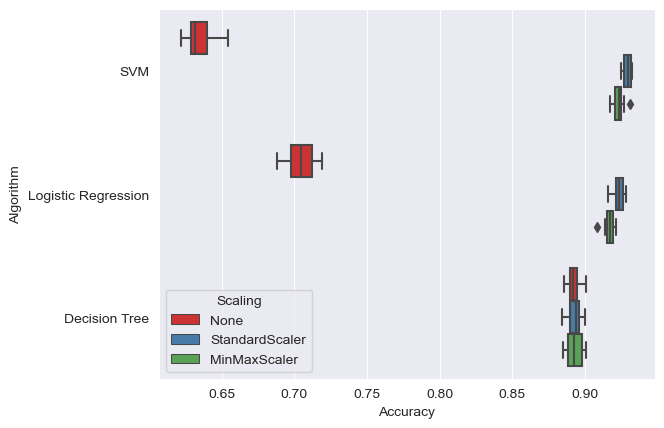

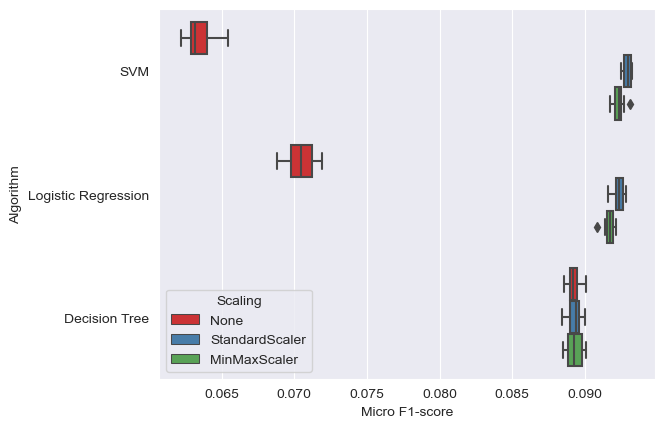

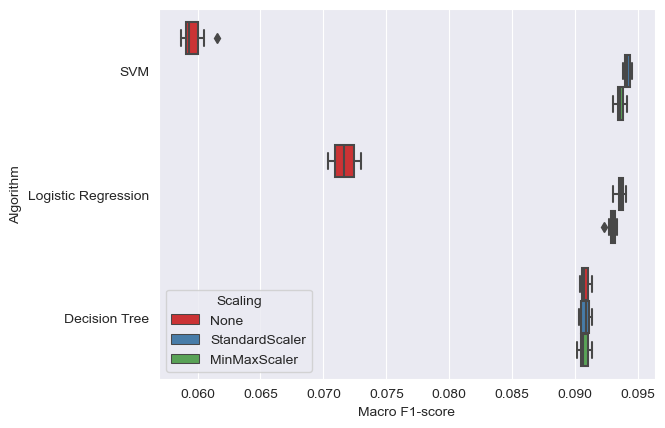

<AxesSubplot:xlabel='Training time', ylabel='Algorithm'>

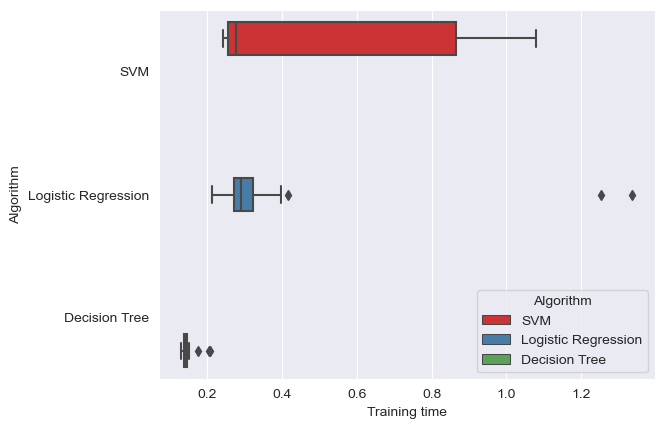

In [198]:
#colors = [(0.21568627450980393, 0.49411764705882355, 0.7215686274509804), (0.8941176470588236, 0.10196078431372549, 0.10980392156862745)]
sns.boxplot(y="Algorithm", x="Accuracy",
            hue="Scaling", palette=sns_palette,
            data=res_ho)
plt.show()
sns.boxplot(y="Algorithm", x="Micro F1-score",
            hue="Scaling", palette=sns_palette,
            data=res_ho)

plt.show()
sns.boxplot(y="Algorithm", x="Macro F1-score",
            hue="Scaling", palette=sns_palette,
            data=res_ho)

plt.show()
sns.boxplot(y="Algorithm", x="Training time",
            hue="Algorithm", palette=sns_palette,
            data=res_ho)

Unsurprisingly, the accuracy, micro f1-score and macro f1-score show extremely similar results. It shows that for SVM and logistic regression, standard scaling unambiguously produces better results than min-max scaling, which are both much better than no scaling at all. For the decision tree algorithm however, we have the confirmation of the theory: scaling does not significantly improve results.

### A function to perform cross-validation training and testing of a model:

In [199]:
def cross_validation(model_label, model, X, y, scale=None):

    # if a scaling method is given, perform scaling
    if scale is not None:
        model = make_pipeline(scale, model)

    # dataframe for results of each fold
    results = pd.DataFrame(columns=['Split/Fold', 'Method',  'Algorithm', 'Scaling', 'Accuracy', 'Micro F1-score', 'Macro F1-score', 'Training time'])

    cval = cross_validate(model, X, y, scoring={'accuracy': 'accuracy',
                                                'f1_micro': 'f1_micro',
                                                'f1_macro': 'f1_macro'},
                          n_jobs=-1)

    for i in range(len(cval['test_accuracy'])):
        # fetch calculated metrics
        acc = cval['test_accuracy'][i]
        mic = cval['test_f1_micro'][i]
        mac = cval['test_f1_macro'][i]
        tr_time = cval['fit_time'][i]

        result =   {'Split/Fold': i+1,
                    'Method': 'Cross-validation',
                    'Algorithm': model_label,
                    'Scaling': 'None' if scale is None else type(scale).__name__,
                    'Accuracy': acc,
                    'Micro f1-score': mic,
                    'Macro f1-score': mac,
                    'Training time': tr_time}
        results.loc[len(results)] = result

    return results

### A function to plot the results of the grid search, once the grid search has yielded scores:

### Make a dataframe to store the results:

In [200]:
res_cv = pd.DataFrame(columns=['Split/Fold', 'Method',  'Algorithm', 'Scaling', 'Accuracy', 'Micro F1-score', 'Macro F1-score', 'Training time'])

Use the support vector machine classifier:

In [201]:
res_cv =  pd.concat([res_cv, cross_validation("SVM", SVC(), X, y)])
res_cv =  pd.concat([res_cv, cross_validation("SVM", SVC(), X, y, scale=StandardScaler())])
res_cv =  pd.concat([res_cv, cross_validation("SVM", SVC(), X, y, scale=MinMaxScaler())])

Use the logistic regression classifier:

In [202]:
res_cv = pd.concat([res_cv, cross_validation("Logistic Regression", LogisticRegression(), X, y)])
res_cv = pd.concat([res_cv, cross_validation("Logistic Regression", LogisticRegression(), X, y, scale=StandardScaler())])
res_cv = pd.concat([res_cv, cross_validation("Logistic Regression", LogisticRegression(), X, y, scale=MinMaxScaler())])

/Users/emilejohnston/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/emilejohnston/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_

Use the decision tree classifier:

In [203]:
res_cv = pd.concat([res_cv, cross_validation("Decision Tree", DecisionTreeClassifier(), X, y)])
res_cv = pd.concat([res_cv, cross_validation("Decision Tree", DecisionTreeClassifier(), X, y, scale=StandardScaler())])
res_cv = pd.concat([res_cv, cross_validation("Decision Tree", DecisionTreeClassifier(), X, y, scale=MinMaxScaler())])

### Show the raw results, with n splits for each configuration:

In [204]:
res_cv

,Split/Fold,Method,Algorithm,Scaling,Accuracy,Micro F1-score,Macro F1-score,Training time
0,1,Cross-validation,SVM,None,0.293059,NaN,NaN,1.357375
1,2,Cross-validation,SVM,None,0.626010,NaN,NaN,1.974770
2,3,Cross-validation,SVM,None,0.767083,NaN,NaN,1.954567
3,4,Cross-validation,SVM,None,0.695077,NaN,NaN,1.971586
4,5,Cross-validation,SVM,None,0.170096,NaN,NaN,1.312537
0,1,Cross-validation,SVM,StandardScaler,0.702901,NaN,NaN,0.296746
1,2,Cross-validation,SVM,StandardScaler,0.969140,NaN,NaN,0.454107
2,3,Cross-validation,SVM,StandardScaler,0.978325,NaN,NaN,0.433788
3,4,Cross-validation,SVM,StandardScaler,0.961058,NaN,NaN,0.412555
4,5,Cross-validation,SVM,StandardScaler,0.662748,NaN,NaN,0.288868


### Show the exact results for average accuracy:

In [205]:
res_cv.groupby(['Algorithm', 'Scaling']).agg({'Accuracy': [ 'min', 'mean', 'max', 'std']})

Accuracy                              
                                         min      mean       max       std
Algorithm           Scaling                                               
Decision Tree       MinMaxScaler    0.281778  0.569545  0.730713  0.189403
                    None            0.279574  0.564549  0.742101  0.191952
                    StandardScaler  0.266716  0.559773  0.732917  0.193979
Logistic Regression MinMaxScaler    0.692506  0.863871  0.975753  0.146436
                    None            0.369581  0.629212  0.808964  0.215843
                    StandardScaler  0.642910  0.847856  0.979427  0.171937
SVM                 MinMaxScaler    0.677810  0.858655  0.977223  0.150526
                    None            0.170096  0.510265  0.767083  0.262870
                    StandardScaler  0.662748  0.854834  0.978325  0.157782

### Make boxplots to show the distribution of accuracy, micro f1-score, macro f1-score and training time for each algorithm and for each scaling method:

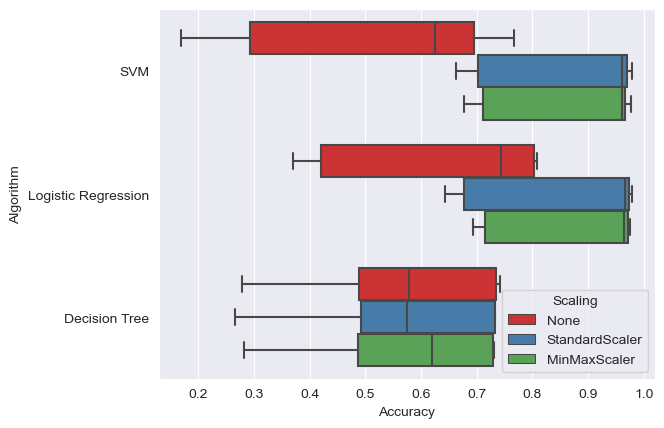

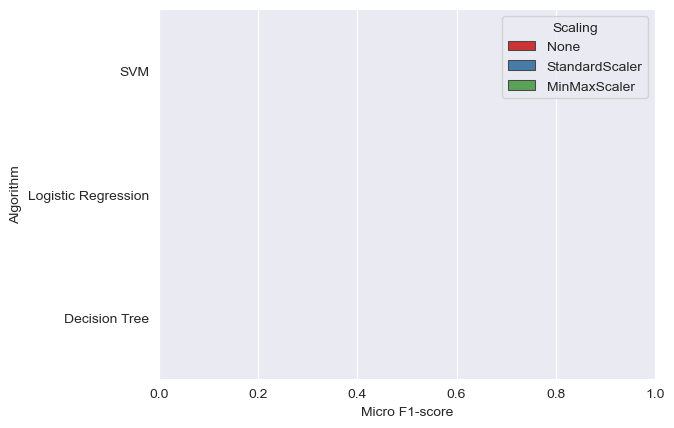

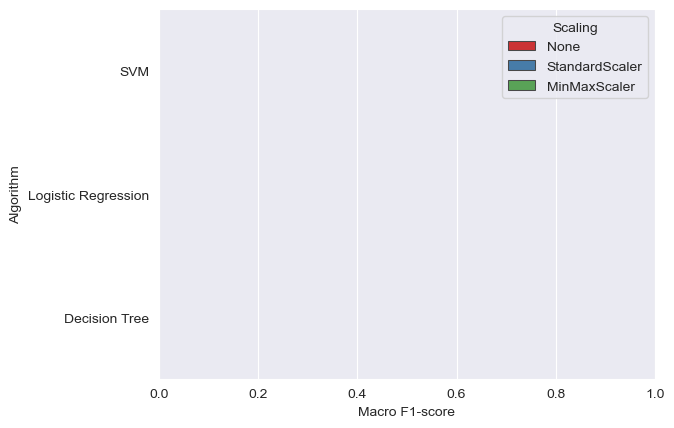

<AxesSubplot:xlabel='Training time', ylabel='Algorithm'>

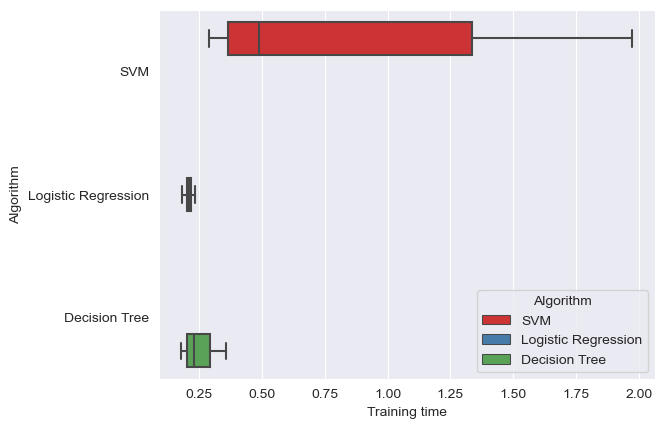

In [206]:
#colors = [(0.21568627450980393, 0.49411764705882355, 0.7215686274509804), (0.8941176470588236, 0.10196078431372549, 0.10980392156862745)]
sns.boxplot(y="Algorithm", x="Accuracy",
            hue="Scaling", palette=sns_palette,
            data=res_cv)
plt.show()
sns.boxplot(y="Algorithm", x="Micro F1-score",
            hue="Scaling", palette=sns_palette,
            data=res_cv)

plt.show()
sns.boxplot(y="Algorithm", x="Macro F1-score",
            hue="Scaling", palette=sns_palette,
            data=res_cv)

plt.show()
sns.boxplot(y="Algorithm", x="Training time",
            hue="Algorithm", palette=sns_palette,
            data=res_cv)

### Join the results from holdout and cross-validation to compare the two methods:

In [207]:
res_joint =  pd.concat([res_ho, res_cv])

### Makes boxplots to visually compare:

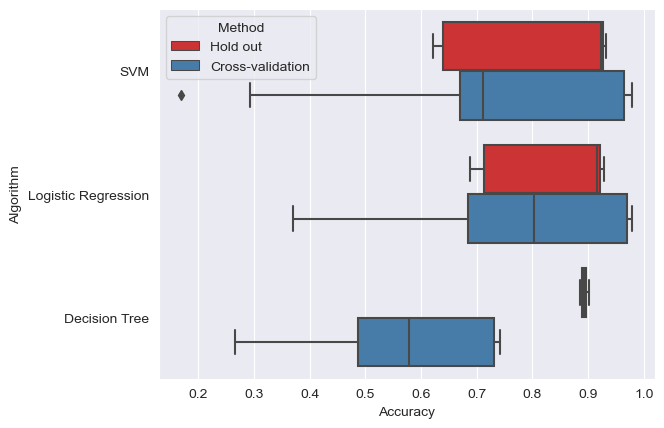

In [208]:
sns.boxplot(y="Algorithm", x="Accuracy",
            hue="Method", palette=sns_palette,
            data=res_joint)
plt.show()

## Hyperparameter tuning

### A function to perform grid search with a given model and given hyperparameters:

In [209]:
from pandas.plotting import parallel_coordinates
import plotly.express as px
import plotly.graph_objects as go
from sklearn.preprocessing import OrdinalEncoder

preproc = lambda x: x.split("__",1)[1]

def plot_grid_search(scores, hyperparameters, scale=None):
    data = pd.DataFrame(hyperparameters)

    # fix feature names
    if scale is not None:
        data.columns = [preproc(col) for col in data.columns.values]

    data['mean_test_score'] = scores

    # fix categorical values
    categorical = data.select_dtypes(exclude='number').columns.values
    for c in categorical:
        oe = OrdinalEncoder()
        data[[c]] = oe.fit_transform(data[[c]])

    fig = px.parallel_coordinates(data, color=data.columns.values[-1], color_continuous_scale=px.colors.sequential.Viridis
                                  )
    fig.show()

def grid_search(model, X, y, hyperparams, scoring=None, plot=True, metric=None, scale=None):
    if scale is not None:
        model = make_pipeline(scale, model)
    else:
        hyperparams = {preproc(k): v for k, v in hyperparams.items()}
    search = GridSearchCV(model, param_grid=hyperparams)
    search.fit(X,y)
    scores = search.cv_results_['mean_test_score']
    hyperparameters = search.cv_results_['params']
    if plot:
        plot_grid_search(scores, hyperparameters, scale)
    return search.best_params_

### Define a range of values for different parameters:

In [210]:
params_svm = {
    'svc__kernel': ['linear', 'poly', 'rbf'],
    'svc__C': [0.01, 0.1, 1, 10, 100],
    'svc__gamma': [0.001, 0.01, 0.1, 1, 10],
}

params_lr = {
    'logisticregression__penalty': ['none','l1', 'l2', 'elasticnet'],
    'logisticregression__C': [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10],
    'logisticregression__solver': ['saga', 'sag', 'lbfgs']
}

params_dt = {
    'decisiontreeclassifier__criterion': ['gini', 'entropy'],
    'decisiontreeclassifier__max_depth': [None, 5, 10, 15],
    'decisiontreeclassifier__min_samples_split': [2, 5, 10],
    'decisiontreeclassifier__min_samples_leaf': [1, 2, 4],
    'decisiontreeclassifier__max_features': ['sqrt', 'log2'],
    'decisiontreeclassifier__ccp_alpha': [0.1, 0.01, 0.001, 0.0001, 0],
}

### Search for the best hyperparameters for SVM:

In [211]:
best_svm = grid_search(SVC(), X, y, hyperparams = params_svm, scale=MinMaxScaler())
best_svm

KeyboardInterrupt: 

### Search for the best hyperparameters for logistic regression:

In [ ]:
best_lr = grid_search(LogisticRegression(), X, y, hyperparams = params_lr, scale=StandardScaler())
best_lr

### Search for the best hyperparameters for decision tree:

In [ ]:
best_dt = grid_search(DecisionTreeClassifier(), X, y, hyperparams = params_dt)
best_dt